TVAE 모델은 1827개의 샘플을 비교함 18273개는 시간이 너무 오래 걸려서 일단 샘플수를 줄여서 비교

# 패키지 , 데이터 불러오기

In [179]:
import os
import pickle 
import sdv.metrics
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [180]:
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/HANBatang.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# 평가척도를 위한 패키지 불러오기

In [181]:
from sdmetrics.single_column import KSComplement
from sdmetrics.column_pairs import CorrelationSimilarity
from sdmetrics.single_column import RangeCoverage
from sdmetrics.single_column import StatisticSimilarity
from sdmetrics.single_column import BoundaryAdherence
from sdmetrics.single_column import CSTest
from sdmetrics.single_table import NewRowSynthesis
from sdv.metadata import SingleTableMetadata # 싱글 메타 데이터의 경우에만! 멀티 메타 데이터의 경우에는 패키지를 다르게 불러와야함
from sdmetrics.reports.single_table import QualityReport 
from sdmetrics.reports.single_table import DiagnosticReport
from sdv.evaluation.single_table import evaluate_quality # Use this function to evaluate the quality of your synthetic data in terms of column shapes and correlations.
from sdv.evaluation.single_table import run_diagnostic # Check to see if the synthetic rows are pure copies of the real data
from sdv.evaluation.single_table import get_column_plot # Use this function to visualize a real column against the same synthetic column

# 서버에서 돌린 데이터 불러오기

### 경상소득(포함) 다변량 정규분포 불러오기

In [167]:
path = "D:/Simulation Data/2023-09-20"

In [168]:
os.chdir(path)

In [169]:
dir_list = os.listdir(path)

In [170]:
print(dir_list)

['all_rho1_mvn.pkl', 'all_rho2_mvn.pkl', 'all_rho3_mvn.pkl', 'all_rho4_mvn.pkl', 'all_rho5_mvn.pkl', 'non_rho1_mvn.pkl', 'non_rho2_mvn.pkl', 'non_rho3_mvn.pkl', 'non_rho4_mvn.pkl', 'non_rho5_mvn.pkl', 'TVAE_all_rho1_data.pkl', 'TVAE_all_rho2_data.pkl', 'TVAE_all_rho3_data.pkl', 'TVAE_all_rho4_data.pkl', 'TVAE_all_rho5_data.pkl', 'TVAE_non_rho1_data.pkl', 'TVAE_non_rho2_data.pkl', 'TVAE_non_rho3_data.pkl', 'TVAE_non_rho4_data.pkl', 'TVAE_non_rho5_data.pkl']


In [9]:
def load_pickle(file_name) : 
    with open(file_name , 'rb') as f:
        return pickle.load(f)

In [171]:
all_rho1_mvn = load_pickle(dir_list[0])
all_rho2_mvn = load_pickle(dir_list[1])
all_rho3_mvn = load_pickle(dir_list[2])
all_rho4_mvn = load_pickle(dir_list[3])
all_rho5_mvn = load_pickle(dir_list[4])

In [172]:
non_rho1_mvn = load_pickle(dir_list[5])
non_rho2_mvn = load_pickle(dir_list[6])
non_rho3_mvn = load_pickle(dir_list[7])
non_rho4_mvn = load_pickle(dir_list[8])
non_rho5_mvn = load_pickle(dir_list[9])

In [173]:
TVAE_all_rho1_data = load_pickle(dir_list[10])
TVAE_all_rho2_data = load_pickle(dir_list[11])
TVAE_all_rho3_data = load_pickle(dir_list[12])
TVAE_all_rho4_data = load_pickle(dir_list[13])
TVAE_all_rho5_data = load_pickle(dir_list[14])

In [174]:
TVAE_non_rho1_data = load_pickle(dir_list[15])
TVAE_non_rho2_data = load_pickle(dir_list[16])
TVAE_non_rho3_data = load_pickle(dir_list[17])
TVAE_non_rho4_data = load_pickle(dir_list[18])
TVAE_non_rho5_data = load_pickle(dir_list[19])

### 미포함 자료에 대한 경상소득(조사) 열 만들기

In [175]:
def sum_income(data) : 
    
    for i in range(500):
        data[i]['경상소득(조사)'] = data[i].iloc[:,1:6].sum(axis = 1)
        

In [176]:
sum_income(non_rho1_mvn)
sum_income(non_rho2_mvn)
sum_income(non_rho3_mvn)
sum_income(non_rho4_mvn)
sum_income(non_rho5_mvn)

In [177]:
sum_income(TVAE_non_rho1_data)
sum_income(TVAE_non_rho2_data)
sum_income(TVAE_non_rho3_data)
sum_income(TVAE_non_rho4_data)
sum_income(TVAE_non_rho5_data)

## 편차 구해주고 평균 , 표준편차 구해주고 데이터프레임으로 만들어주는 함수

In [178]:
def unbiased(variable, synthetic_data, mvn_data, iteration):
    
    diffs = np.zeros((iteration, 7))  

    for i in range(iteration):
        diffs[i, 0] = synthetic_data[i][variable].mean() - mvn_data[i][variable].mean()
        diffs[i, 1] = synthetic_data[i][variable].std() - mvn_data[i][variable].std()
        diffs[i, 2] = np.quantile(synthetic_data[i][variable], q=0.25) - np.quantile(mvn_data[i][variable], q=0.25)
        diffs[i, 3] = np.quantile(synthetic_data[i][variable], q=0.50) - np.quantile(mvn_data[i][variable], q=0.50)
        diffs[i, 4] = np.quantile(synthetic_data[i][variable], q=0.75) - np.quantile(mvn_data[i][variable], q=0.75)
        diffs[i, 5] = np.quantile(synthetic_data[i][variable], q=0.90) - np.quantile(mvn_data[i][variable], q=0.90)
        diffs[i, 6] = np.quantile(synthetic_data[i][variable], q=0.99) - np.quantile(mvn_data[i][variable], q=0.99)

    # 평균과 표준편차 계산
    mean_diff = np.mean(diffs, axis=0)
    std_diff = np.std(diffs, axis=0)

    # 결과 DataFrame 생성
    result = pd.DataFrame({'Bias의 평균': mean_diff, 'Bias의 표준편차': std_diff},
                          index=['평균', '표준편차', '25%', '50%', '75%', '90%', '99%'])
    
    return result


### 경상소득(조사) 포함 된 것에 대한 데이터프레임

In [182]:
b1 = unbiased('경상소득(조사)' , TVAE_all_rho1_data , all_rho1_mvn , 500)
b2 = unbiased('경상소득(조사)' , TVAE_all_rho2_data , all_rho2_mvn , 500)
b3 = unbiased('경상소득(조사)' , TVAE_all_rho3_data , all_rho3_mvn , 500)
b4 = unbiased('경상소득(조사)' , TVAE_all_rho4_data , all_rho4_mvn , 500)
b5 = unbiased('경상소득(조사)' , TVAE_all_rho5_data , all_rho5_mvn , 500)

pd.concat([b1,b2,b3,b4,b5] , axis = 1)

,Bias의 평균,Bias의 표준편차,Bias의 평균,Bias의 표준편차,Bias의 평균,Bias의 표준편차,Bias의 평균,Bias의 표준편차,Bias의 평균,Bias의 표준편차
평균,-186.845567,2350.245826,44.302570,1565.246730,-28.422610,1037.172725,12.792305,774.011980,-5.219442,576.549743
표준편차,-1089.534010,721.745418,-320.980574,659.912051,-146.415976,566.428814,-129.683683,502.820837,-206.509297,454.532150
25%,539.788094,2504.467505,29.297714,1897.658464,-388.186385,1320.366852,-426.673880,1030.431078,-366.560638,841.721065
50%,-181.798567,2577.776750,80.056391,2152.151922,-66.136854,1736.702110,53.062260,1435.212266,-28.431012,1159.753902
75%,-921.260265,2534.035307,62.326636,1962.077021,318.532904,1327.099850,428.826427,1048.252543,335.185916,878.445526
90%,-1601.007812,2470.725248,-338.367898,1583.715130,-109.871477,1037.538776,-108.579573,921.163401,-170.837312,823.218178
99%,-2840.382416,2353.524312,-1661.329636,1401.423095,-1664.757251,1250.516760,-1710.850604,1180.401588,-1718.582524,1104.187049


### 경상소득(조사) 포함 되지 않은것에 대한 데이터프레임

In [183]:
a1 = unbiased('경상소득(조사)' , TVAE_non_rho1_data , non_rho1_mvn , 500)
a2 = unbiased('경상소득(조사)' , TVAE_non_rho2_data , non_rho2_mvn , 500)
a3 = unbiased('경상소득(조사)' , TVAE_non_rho3_data , non_rho3_mvn , 500)
a4 = unbiased('경상소득(조사)' , TVAE_non_rho4_data , non_rho4_mvn , 500)
a5 = unbiased('경상소득(조사)' , TVAE_non_rho5_data , non_rho5_mvn , 500)

pd.concat([a1,a2,a3,a4,a5] , axis = 1)

,Bias의 평균,Bias의 표준편차,Bias의 평균,Bias의 표준편차,Bias의 평균,Bias의 표준편차,Bias의 평균,Bias의 표준편차,Bias의 평균,Bias의 표준편차
평균,-78.159225,2619.219256,2.620776,1852.368361,-18.214685,1160.230670,9.721586,970.605654,-4.190167,784.846537
표준편차,-1097.895202,713.856904,7.332796,796.158397,306.272385,646.054025,-222.752549,567.576027,-857.636086,569.461509
25%,624.876184,2741.839211,-533.169480,2294.252204,-1554.820689,1494.576429,-1328.202716,1278.660382,-937.222062,1113.045121
50%,-89.768438,2779.731204,-26.168838,2642.278031,-29.075234,2338.785140,-15.410391,2205.151152,59.133100,1954.200220
75%,-791.542895,2793.241709,514.203466,2264.731651,1528.931715,1524.366801,1355.464289,1216.542105,899.291422,1159.938312
90%,-1461.030958,2753.239071,263.534123,1763.977779,561.788553,1152.581098,-157.411347,991.572883,-1045.207244,996.155633
99%,-2749.870654,2641.430105,-1696.551804,1501.322931,-2678.202605,1296.312135,-4181.165011,1308.991342,-5638.053655,1375.172538


### 평균에 대한 박스플랏 ( 경상소득 포함)

#### 첫번째부터 $\rho$ = 0.1 , 0.3 , 0.5 , 0.7 , 0.9 일때 A = 다변량 원자료 , B = 재현자료

In [184]:
def all_boxplot(variable, statistic, iteration):
    plt.rcParams['figure.figsize'] = (8, 8)
    plt.rcParams['font.size'] = 10
    fig, ax = plt.subplots()
    
    data_to_plot = []
    
    for i in range(1, 6):
        original = eval(f'all_rho{i}_mvn')
        synthetic = eval(f'TVAE_all_rho{i}_data') 
        
        if statistic == 'mean':
            a = [np.mean(original[j][variable]) for j in range(iteration)]
            b = [np.mean(synthetic[j][variable]) for j in range(iteration)]
        elif statistic == 'std':
            a = [np.std(original[j][variable]) for j in range(iteration)]
            b = [np.std(synthetic[j][variable]) for j in range(iteration)]
        elif statistic == '25%':
            a = [np.quantile(original[j][variable] , q = .25) for j in range(iteration)]
            b = [np.quantile(synthetic[j][variable] , q = .25) for j in range(iteration)]
        elif statistic == '50%':
            a = [np.quantile(original[j][variable] , q = .50) for j in range(iteration)]
            b = [np.quantile(synthetic[j][variable], q = .50) for j in range(iteration)]
        elif statistic == '75%':
            a = [np.quantile(original[j][variable], q = .75) for j in range(iteration)]
            b = [np.quantile(synthetic[j][variable], q = .75) for j in range(iteration)]
        elif statistic == '90%':
            a = [np.quantile(original[j][variable], q = .90) for j in range(iteration)]
            b = [np.quantile(synthetic[j][variable], q = .90) for j in range(iteration)]
        elif statistic == '99%':
            a = [np.quantile(original[j][variable], q = .99) for j in range(iteration)]
            b = [np.quantile(synthetic[j][variable], q = .99) for j in range(iteration)]        
        else:
            raise ValueError("no invalid statistic")

        data_to_plot.append(a)
        data_to_plot.append(b)
        
    ax.boxplot(data_to_plot, labels=['A', 'B'] * 5)
    ax.set_xlabel('Data Type')
    ax.set_ylabel('Value')
    plt.title(statistic.capitalize())  # 선택한 통계량에 따라 그래프 제목 설정
    plt.show()

In [185]:
def non_all_boxplot(variable, statistic, iteration):
    plt.rcParams['figure.figsize'] = (8, 8)
    plt.rcParams['font.size'] = 10
    fig, ax = plt.subplots()
    
    data_to_plot = []
    
    for i in range(1, 6):
        original = eval(f'non_rho{i}_mvn')
        synthetic = eval(f'TVAE_non_rho{i}_data') 
        
        if statistic == 'mean':
            a = [np.mean(original[j][variable]) for j in range(iteration)]
            b = [np.mean(synthetic[j][variable]) for j in range(iteration)]
        elif statistic == 'std':
            a = [np.std(original[j][variable]) for j in range(iteration)]
            b = [np.std(synthetic[j][variable]) for j in range(iteration)]
        elif statistic == '25%':
            a = [np.quantile(original[j][variable] , q = .25) for j in range(iteration)]
            b = [np.quantile(synthetic[j][variable] , q = .25) for j in range(iteration)]
        elif statistic == '50%':
            a = [np.quantile(original[j][variable] , q = .50) for j in range(iteration)]
            b = [np.quantile(synthetic[j][variable], q = .50) for j in range(iteration)]
        elif statistic == '75%':
            a = [np.quantile(original[j][variable], q = .75) for j in range(iteration)]
            b = [np.quantile(synthetic[j][variable], q = .75) for j in range(iteration)]
        elif statistic == '90%':
            a = [np.quantile(original[j][variable], q = .90) for j in range(iteration)]
            b = [np.quantile(synthetic[j][variable], q = .90) for j in range(iteration)]
        elif statistic == '99%':
            a = [np.quantile(original[j][variable], q = .99) for j in range(iteration)]
            b = [np.quantile(synthetic[j][variable], q = .99) for j in range(iteration)]        
        else:
            raise ValueError("no invalid statistic")

        data_to_plot.append(a)
        data_to_plot.append(b)
        
    ax.boxplot(data_to_plot, labels=['A', 'B'] * 5)
    ax.set_xlabel('Data Type')
    ax.set_ylabel('Value')
    plt.title(statistic.capitalize())  # 선택한 통계량에 따라 그래프 제목 설정
    plt.show()

### 평균에 대한 박스플랏 ( 경상소득 미포함)

#### 첫번째부터 $\rho$ = 0.1 , 0.3 , 0.5 , 0.7 , 0.9 일때 A = 다변량 원자료 , B = 재현자료

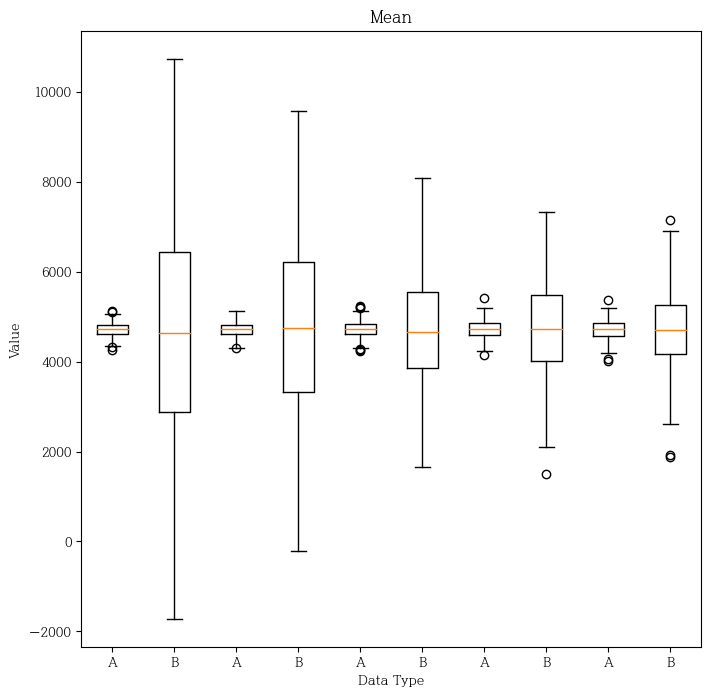

In [186]:
non_all_boxplot(variable = "경상소득(조사)" , statistic = 'mean' , iteration = 500)

### 평균에 대한 박스플랏 ( 경상소득 포함)

#### 첫번째부터 $\rho$ = 0.1 , 0.3 , 0.5 , 0.7 , 0.9 일때 A = 다변량 원자료 , B = 재현자료

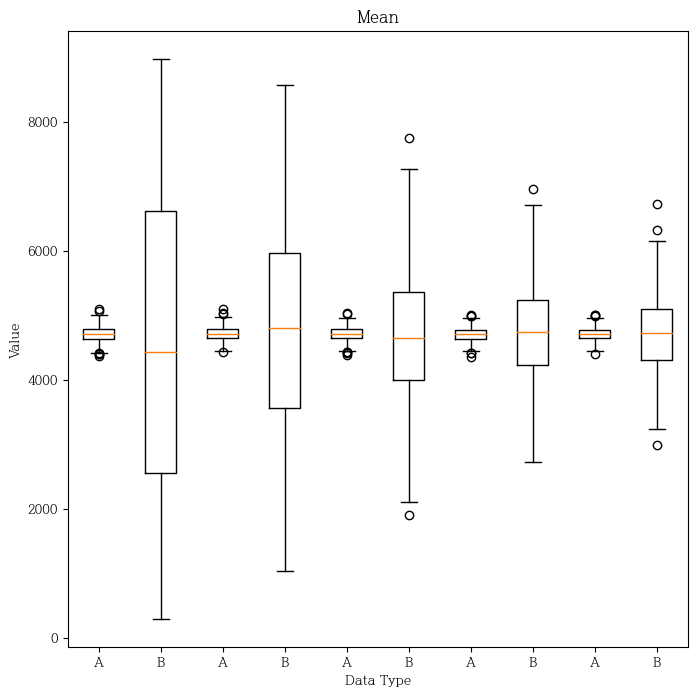

In [187]:
all_boxplot(variable = "경상소득(조사)" , statistic = 'mean' , iteration = 500)

### 표준편차에 대한 박스플랏 ( 경상소득 미포함)

#### 첫번째부터 $\rho$ = 0.1 , 0.3 , 0.5 , 0.7 , 0.9 일때 A = 다변량 원자료 , B = 재현자료

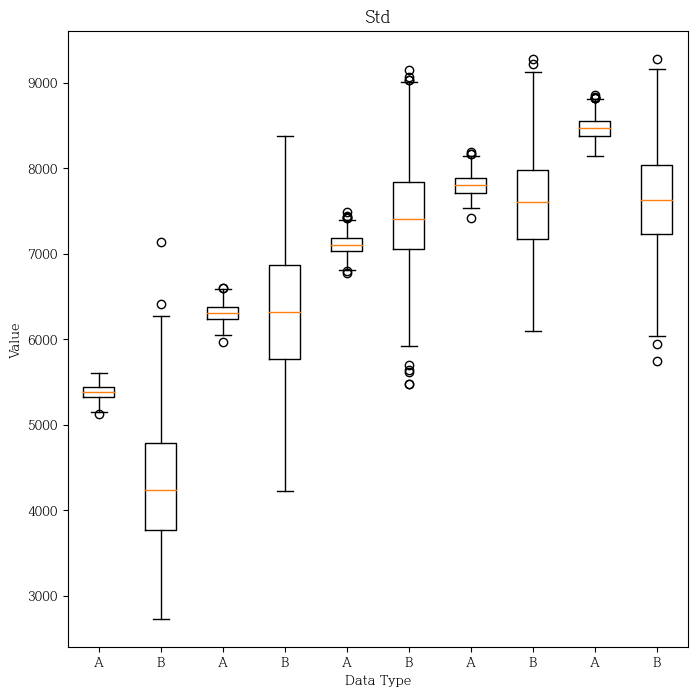

In [188]:
non_all_boxplot(variable = "경상소득(조사)" , statistic = 'std' , iteration = 500)

### 표준편차에 대한 박스플랏 ( 경상소득 포함)

#### 첫번째부터 $\rho$ = 0.1 , 0.3 , 0.5 , 0.7 , 0.9 일때 A = 다변량 원자료 , B = 재현자료

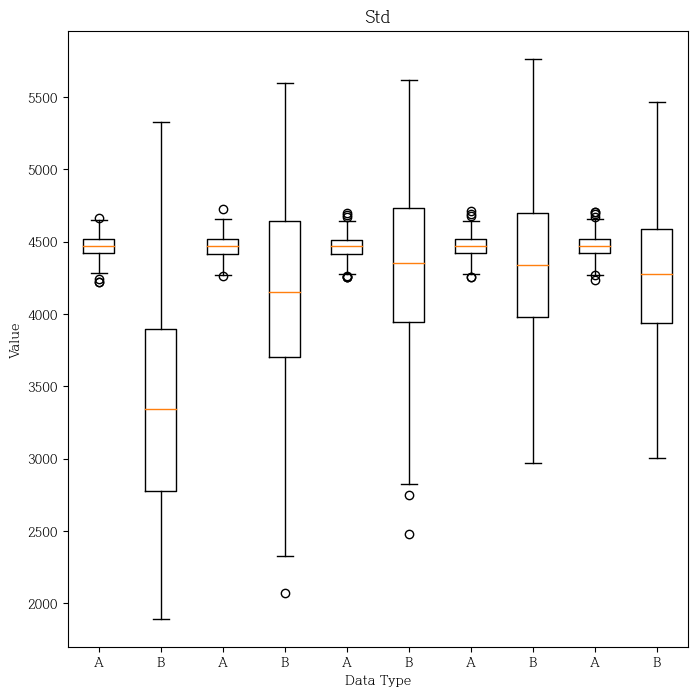

In [189]:
all_boxplot(variable = "경상소득(조사)" , statistic = 'std' , iteration = 500)

### 25% 분위수에 대한 박스플랏 ( 경상소득 미포함)

#### 첫번째부터 $\rho$ = 0.1 , 0.3 , 0.5 , 0.7 , 0.9 일때 A = 다변량 원자료 , B = 재현자료

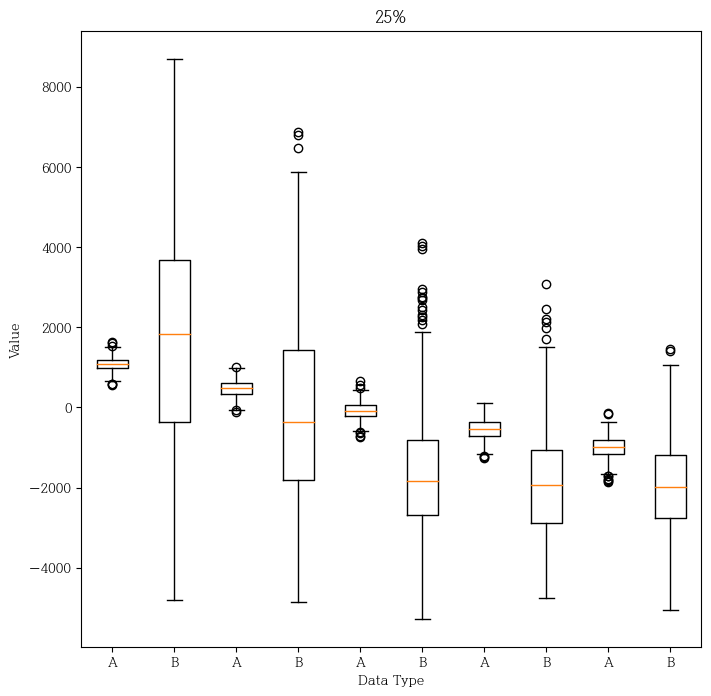

In [190]:
non_all_boxplot(variable = "경상소득(조사)" , statistic = '25%' , iteration = 500)

### 25% 분위수에 대한 박스플랏 ( 경상소득 포함)

#### 첫번째부터 $\rho$ = 0.1 , 0.3 , 0.5 , 0.7 , 0.9 일때 A = 다변량 원자료 , B = 재현자료

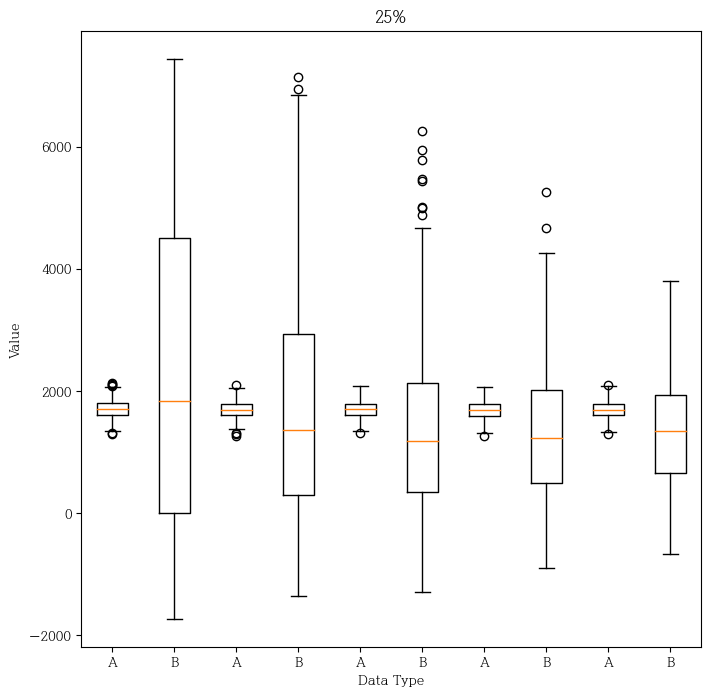

In [191]:
all_boxplot(variable = "경상소득(조사)" , statistic = '25%' , iteration = 500)

### 50% 분위수에 대한 박스플랏 ( 경상소득 미포함)

#### 첫번째부터 $\rho$ = 0.1 , 0.3 , 0.5 , 0.7 , 0.9 일때 A = 다변량 원자료 , B = 재현자료

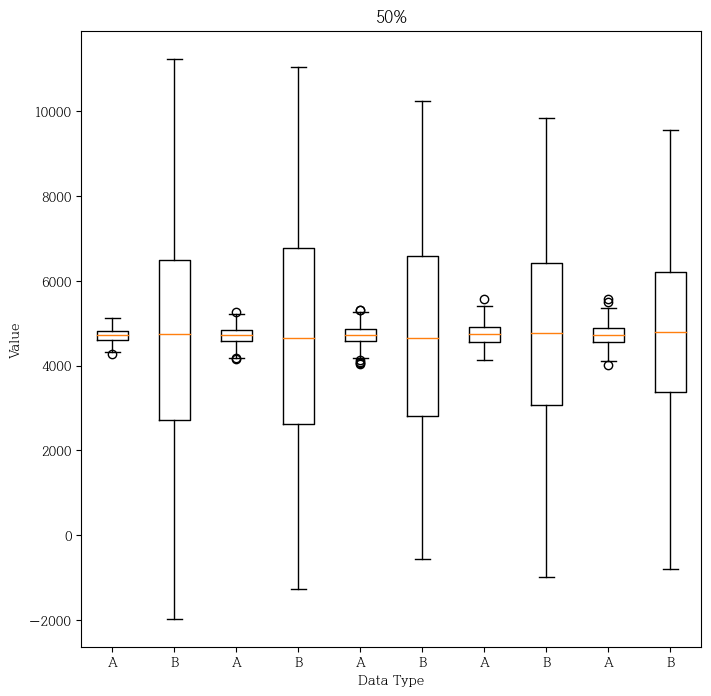

In [192]:
non_all_boxplot(variable = "경상소득(조사)" , statistic = '50%' , iteration = 500)

### 50% 분위수에 대한 박스플랏 ( 경상소득 포함)

#### 첫번째부터 $\rho$ = 0.1 , 0.3 , 0.5 , 0.7 , 0.9 일때 A = 다변량 원자료 , B = 재현자료

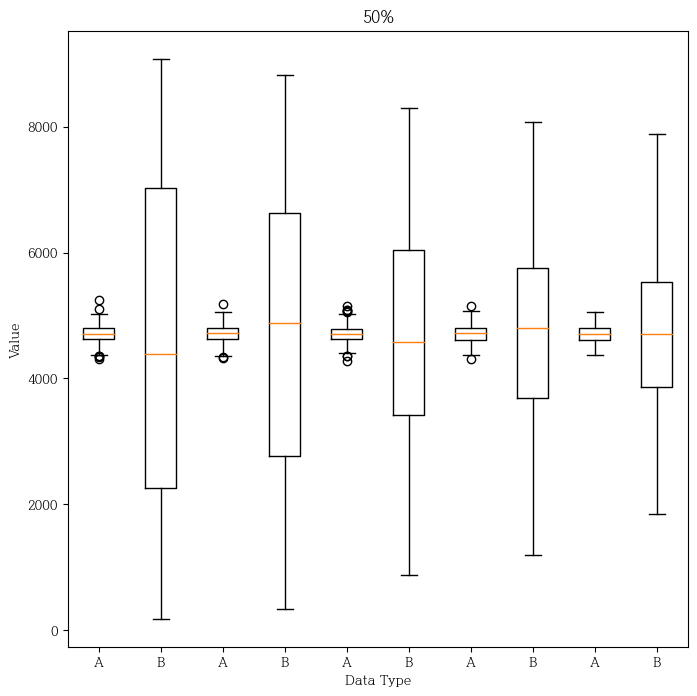

In [193]:
all_boxplot(variable = "경상소득(조사)" , statistic = '50%' , iteration = 500)

### 75% 분위수에 대한 박스플랏 ( 경상소득 미포함)

#### 첫번째부터 $\rho$ = 0.1 , 0.3 , 0.5 , 0.7 , 0.9 일때 A = 다변량 원자료 , B = 재현자료

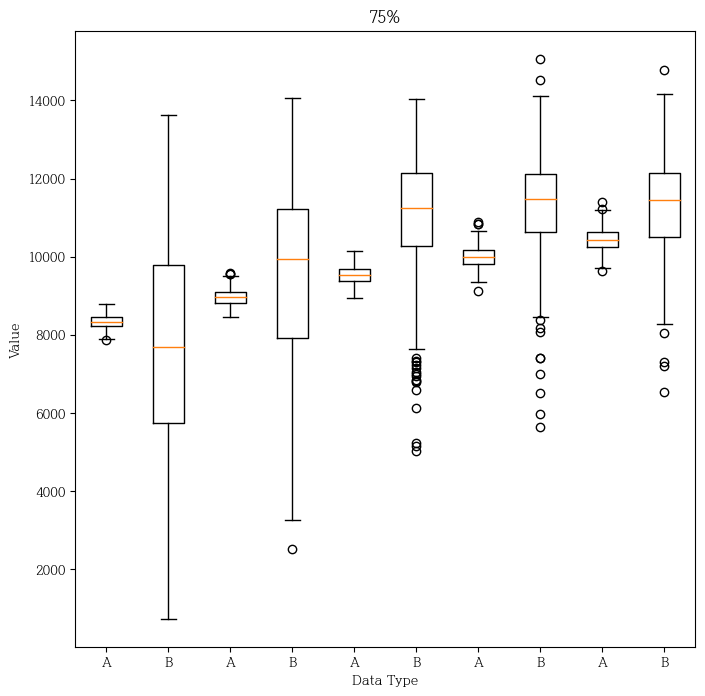

In [194]:
non_all_boxplot(variable = "경상소득(조사)" , statistic = '75%' , iteration = 500)

### 75% 분위수에 대한 박스플랏 ( 경상소득 포함)

#### 첫번째부터 $\rho$ = 0.1 , 0.3 , 0.5 , 0.7 , 0.9 일때 A = 다변량 원자료 , B = 재현자료

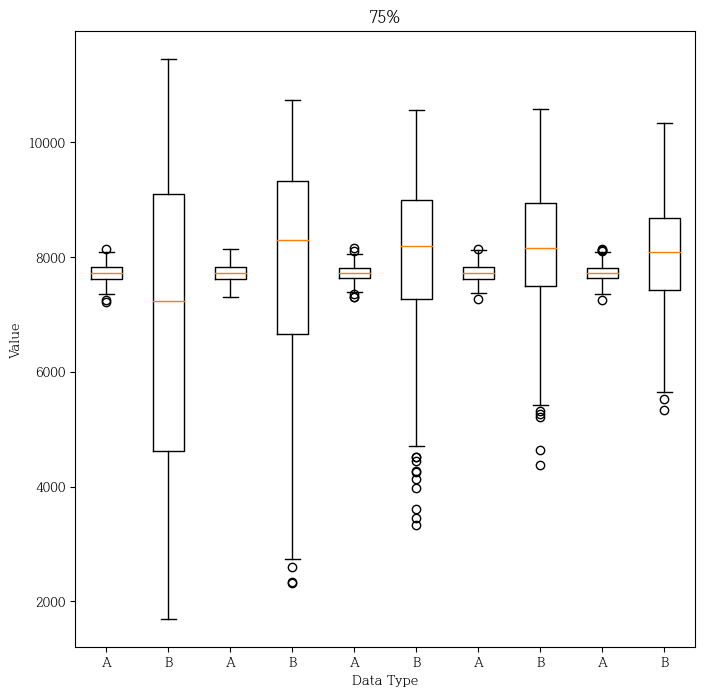

In [195]:
all_boxplot(variable = "경상소득(조사)" , statistic = '75%' , iteration = 500)

### 90% 분위수에 대한 박스플랏 ( 경상소득 미포함)

#### 첫번째부터 $\rho$ = 0.1 , 0.3 , 0.5 , 0.7 , 0.9 일때 A = 다변량 원자료 , B = 재현자료

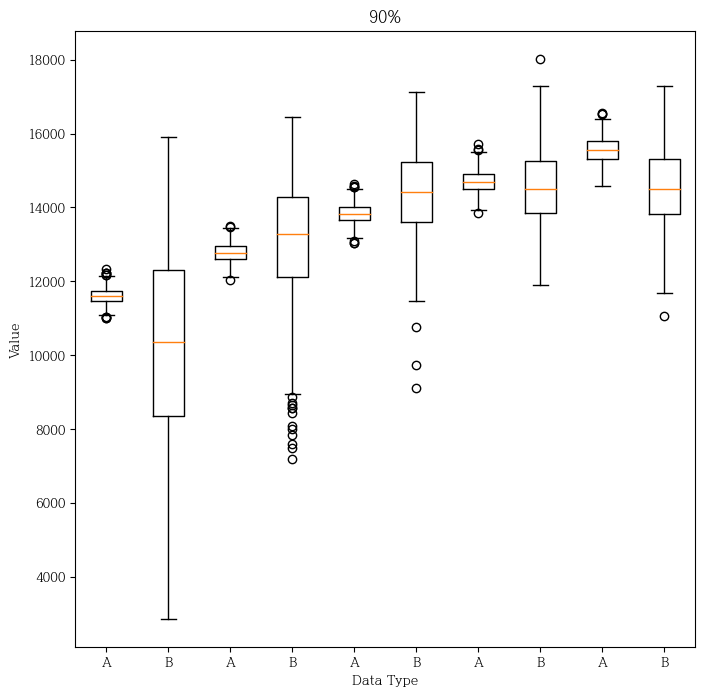

In [196]:
non_all_boxplot(variable = "경상소득(조사)" , statistic = '90%' , iteration = 500)

### 90% 분위수에 대한 박스플랏 ( 경상소득 포함)

#### 첫번째부터 $\rho$ = 0.1 , 0.3 , 0.5 , 0.7 , 0.9 일때 A = 다변량 원자료 , B = 재현자료

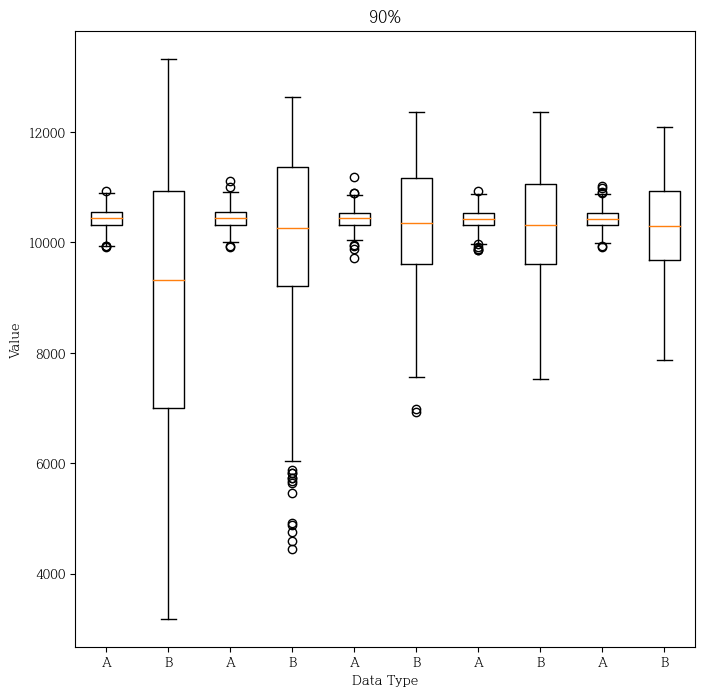

In [197]:
all_boxplot(variable = "경상소득(조사)" , statistic = '90%' , iteration = 500)

### 99% 분위수에 대한 박스플랏 ( 경상소득 미포함)

#### 첫번째부터 $\rho$ = 0.1 , 0.3 , 0.5 , 0.7 , 0.9 일때 A = 다변량 원자료 , B = 재현자료

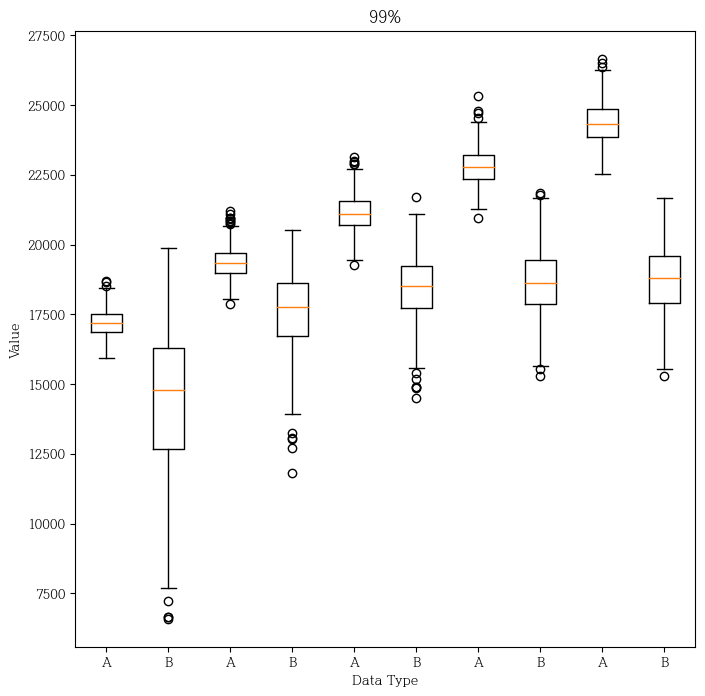

In [198]:
non_all_boxplot(variable = "경상소득(조사)" , statistic = '99%' , iteration = 500)

### 99% 분위수에 대한 박스플랏 ( 경상소득 포함)

#### 첫번째부터 $\rho$ = 0.1 , 0.3 , 0.5 , 0.7 , 0.9 일때 A = 다변량 원자료 , B = 재현자료

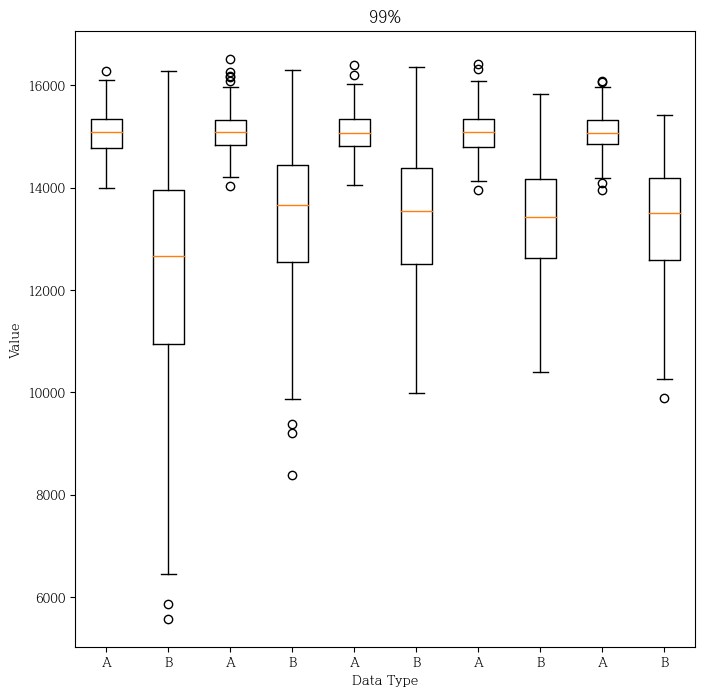

In [199]:
all_boxplot(variable = "경상소득(조사)" , statistic = '99%' , iteration = 500)

### 그래프 일대일로 겹처서 그리기 ( 첫번째 시뮬레이션 결과에 대해서 )

In [211]:
def one_by_scatter(data1 , data2 , variable1 , variable2):
        
    plt.rcParams['figure.figsize'] = (8, 8)
    plt.rcParams['font.size'] = 10
    fig, ax = plt.subplots()
    
    plt.scatter(data1[variable1], data1[variable2] , color = 'purple' , alpha = 0.3 , label = '원자료')
    plt.scatter(data2[variable1], data2[variable2] , color = 'orange' , alpha = 0.3 , label = "재현자료")
    plt.legend()
    ax.set_xlabel(variable1)
    ax.set_ylabel(variable2)
    plt.title('plot')  # 선택한 통계량에 따라 그래프 제목 설정
    plt.show()

### 경상소득이 포함되지 않은 자료에 대한 그래프

#### $\rho$ = 0.1

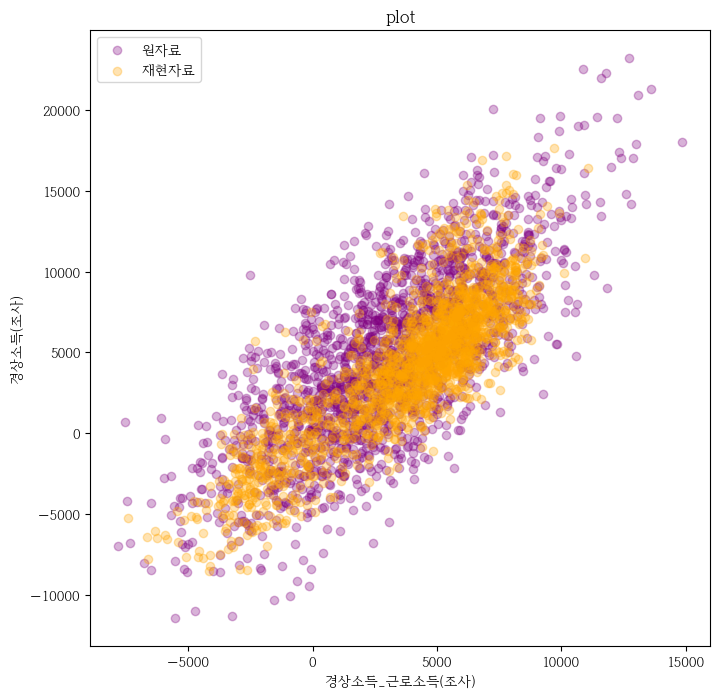

In [212]:
one_by_scatter(non_rho1_mvn[0] , TVAE_non_rho1_data[0] ,'경상소득_근로소득(조사)' ,  '경상소득(조사)' )

#### $\rho$ = 0.3

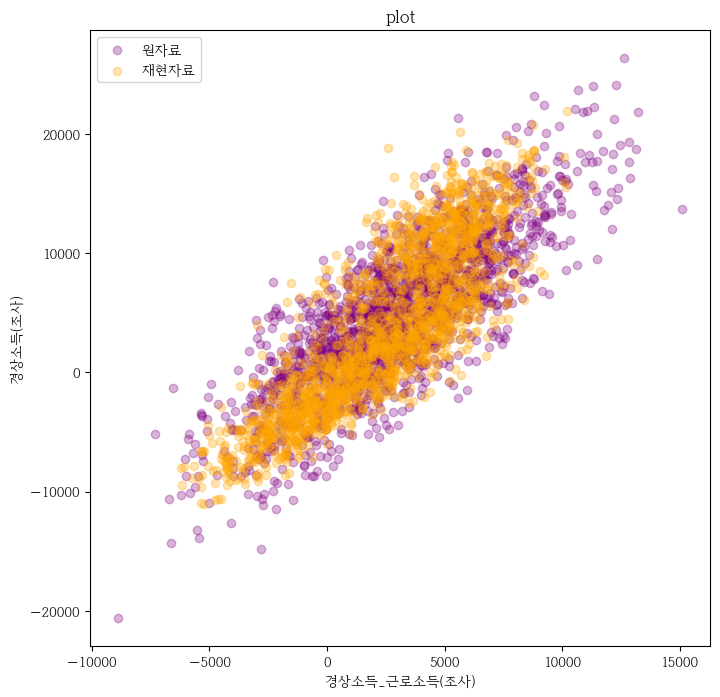

In [213]:
one_by_scatter(non_rho2_mvn[0] , TVAE_non_rho2_data[0] , '경상소득_근로소득(조사)' , '경상소득(조사)')

#### $\rho$ = 0.5

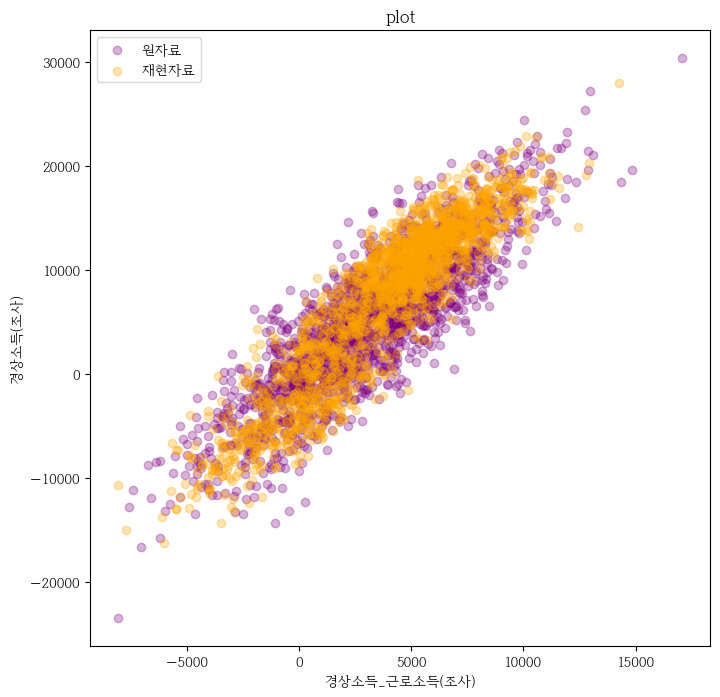

In [214]:
one_by_scatter(non_rho3_mvn[0] , TVAE_non_rho3_data[0] , '경상소득_근로소득(조사)' , '경상소득(조사)')

#### $\rho$ = 0.7

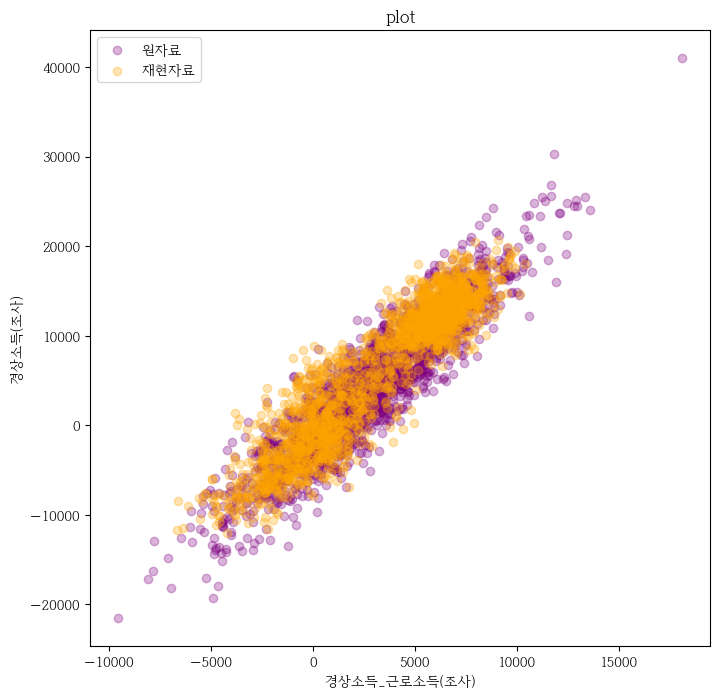

In [215]:
one_by_scatter(non_rho4_mvn[0] , TVAE_non_rho4_data[0] , '경상소득_근로소득(조사)' , '경상소득(조사)')

#### $\rho$ = 0.9

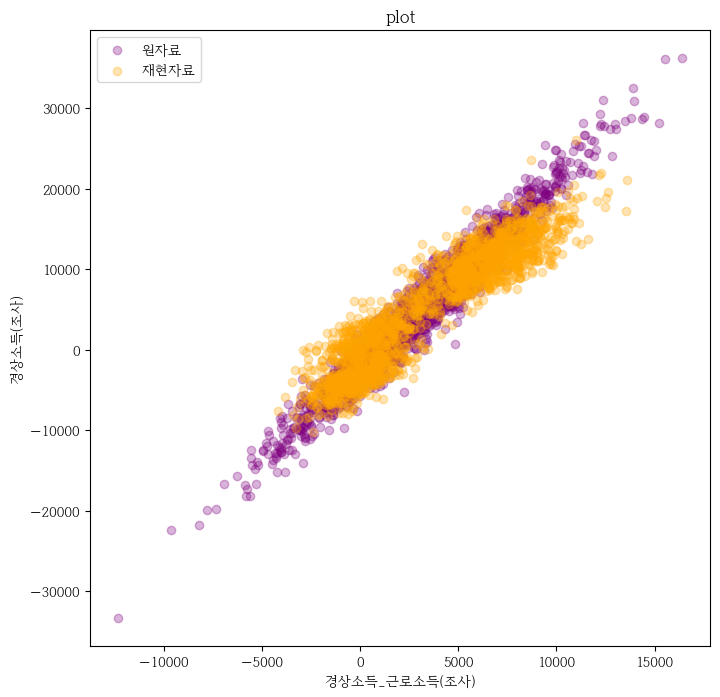

In [216]:
one_by_scatter(non_rho5_mvn[0] , TVAE_non_rho5_data[0] ,'경상소득_근로소득(조사)' , '경상소득(조사)')

### 경상소득이 포함된 자료에 대한 그래프

#### $\rho$ = 0.1

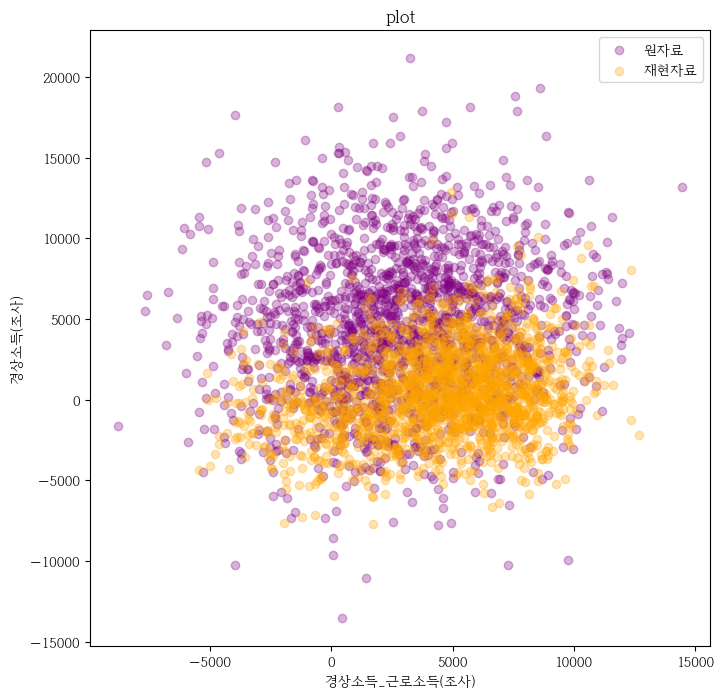

In [217]:
one_by_scatter(all_rho1_mvn[0] , TVAE_all_rho1_data[0] ,'경상소득_근로소득(조사)' , '경상소득(조사)')

#### $\rho$ = 0.3

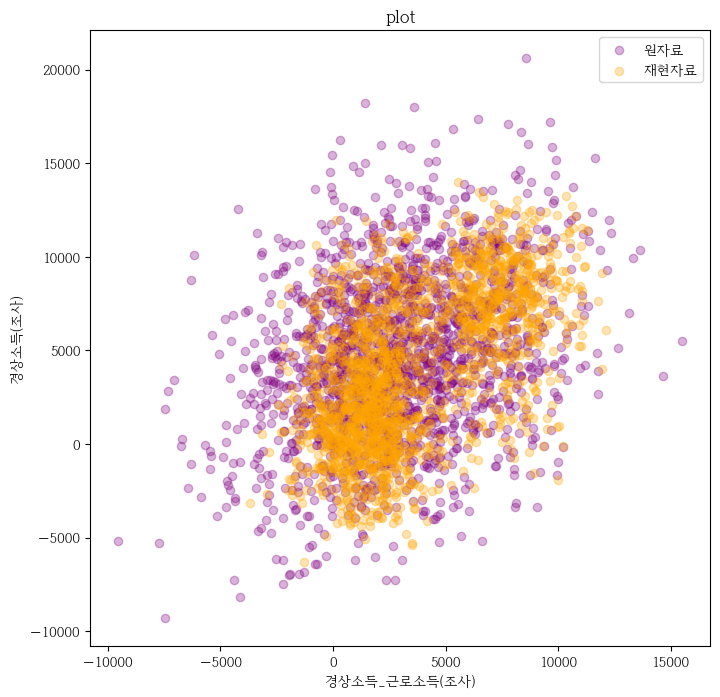

In [219]:
one_by_scatter(all_rho2_mvn[0] , TVAE_all_rho2_data[0] ,'경상소득_근로소득(조사)' , '경상소득(조사)')

#### $\rho$ = 0.5

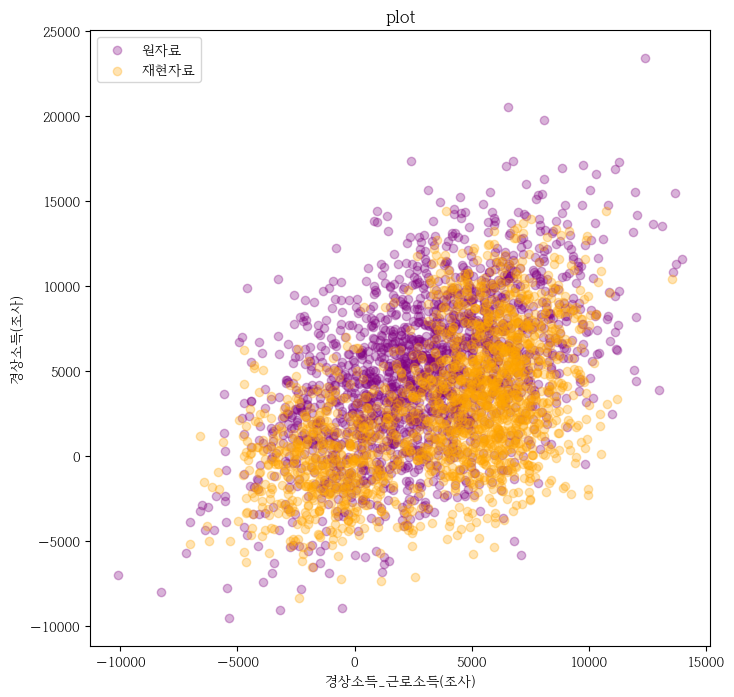

In [220]:
one_by_scatter(all_rho3_mvn[0] , TVAE_all_rho3_data[0] ,'경상소득_근로소득(조사)' , '경상소득(조사)')

#### $\rho$ = 0.7

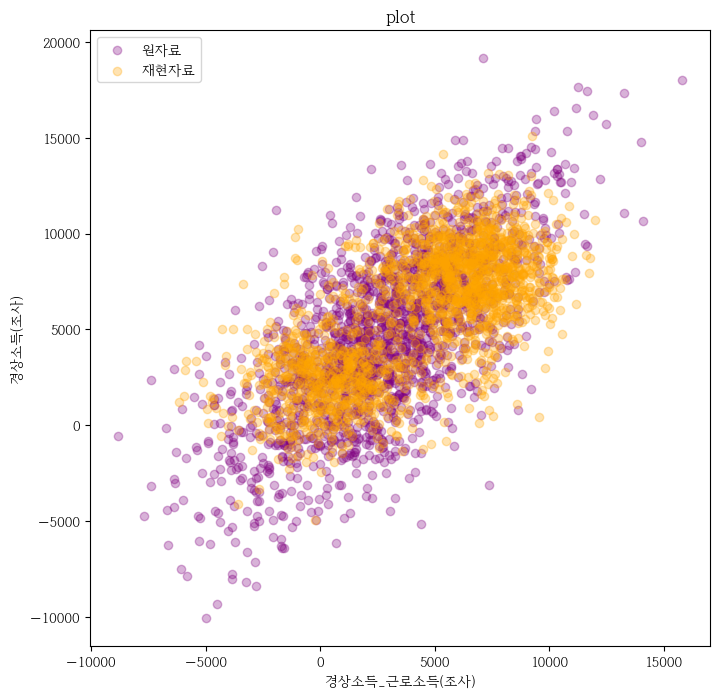

In [221]:
one_by_scatter(all_rho4_mvn[0] , TVAE_all_rho4_data[0] ,'경상소득_근로소득(조사)' , '경상소득(조사)')

#### $\rho$ = 0.9

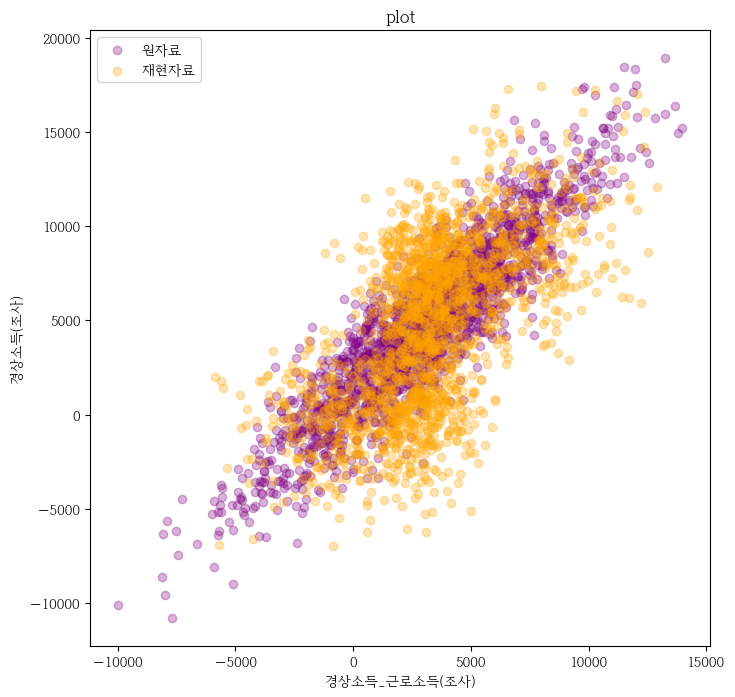

In [222]:
one_by_scatter(all_rho5_mvn[0] , TVAE_all_rho5_data[0] , '경상소득_근로소득(조사)' , '경상소득(조사)')

### 경상소득이 포함되지 않은 자료에 대한 상관계수 그래프 

#### $\rho$ = 0.1

Text(0.5, 1.0, '전체재현자료')

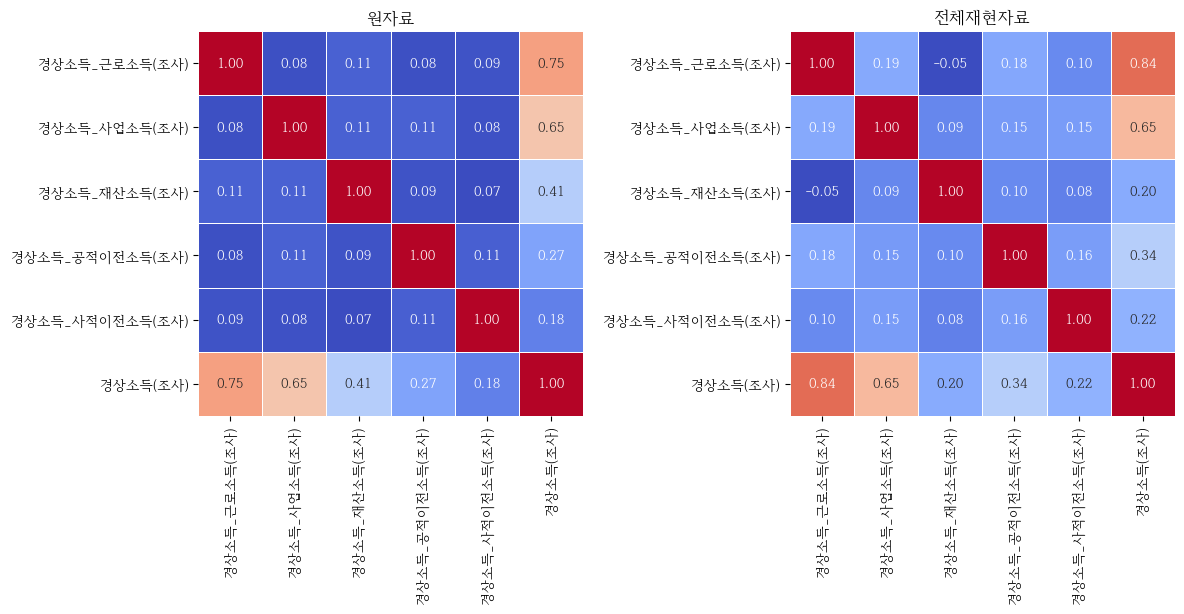

In [255]:
plt.subplot(1,2,1)
plt.rcParams["figure.figsize"] = (14,5)
sns.heatmap(non_rho1_mvn[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True , cbar = False)
plt.title("원자료")

plt.subplot(1,2,2)
sns.heatmap(TVAE_non_rho1_data[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True , cbar = False)
plt.title("전체재현자료")

#### $\rho$ = 0.3

Text(0.5, 1.0, '전체재현자료')

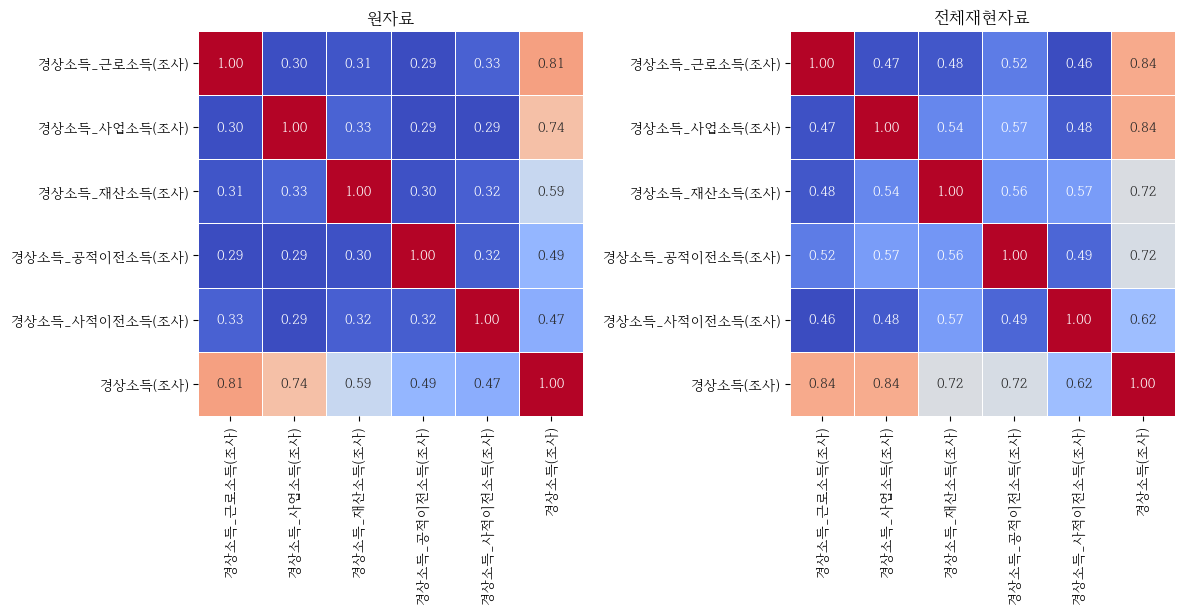

In [254]:
plt.subplot(1,2,1)
plt.rcParams["figure.figsize"] = (14,5)
sns.heatmap(non_rho2_mvn[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True , cbar = False)
plt.title("원자료")

plt.subplot(1,2,2)
sns.heatmap(TVAE_non_rho2_data[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True , cbar = False)
plt.title("전체재현자료")

#### $\rho$ = 0.5

Text(0.5, 1.0, '전체재현자료')

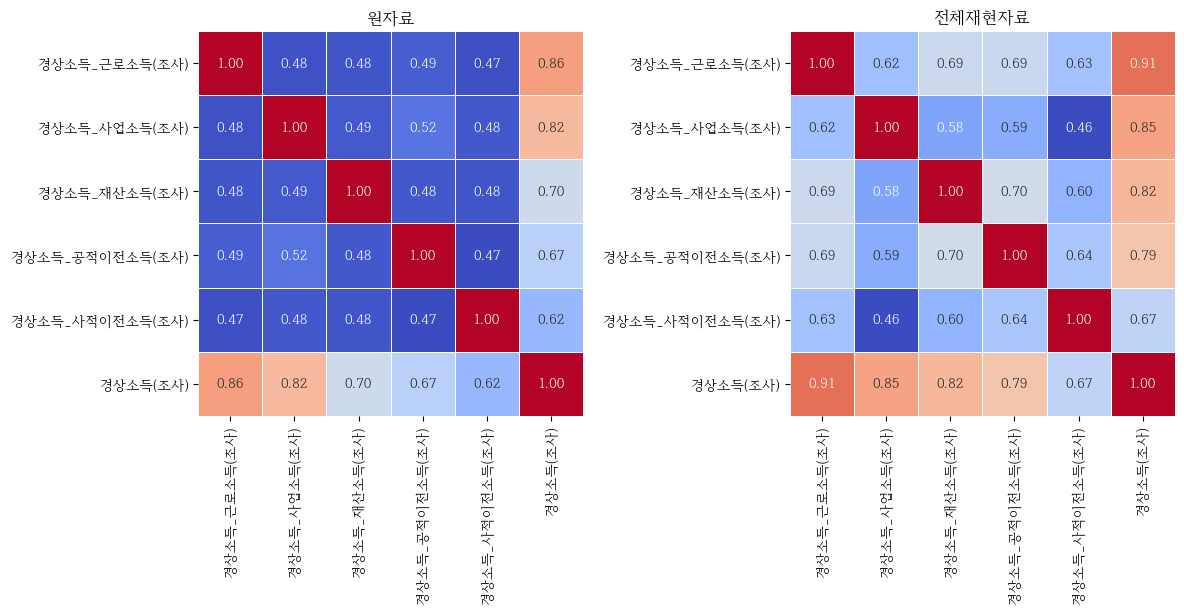

In [256]:
plt.subplot(1,2,1)
plt.rcParams["figure.figsize"] = (14,5)
sns.heatmap(non_rho3_mvn[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True , cbar = False)
plt.title("원자료")

plt.subplot(1,2,2)
sns.heatmap(TVAE_non_rho3_data[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True , cbar = False)
plt.title("전체재현자료")

#### $\rho$ = 0.7

Text(0.5, 1.0, '전체재현자료')

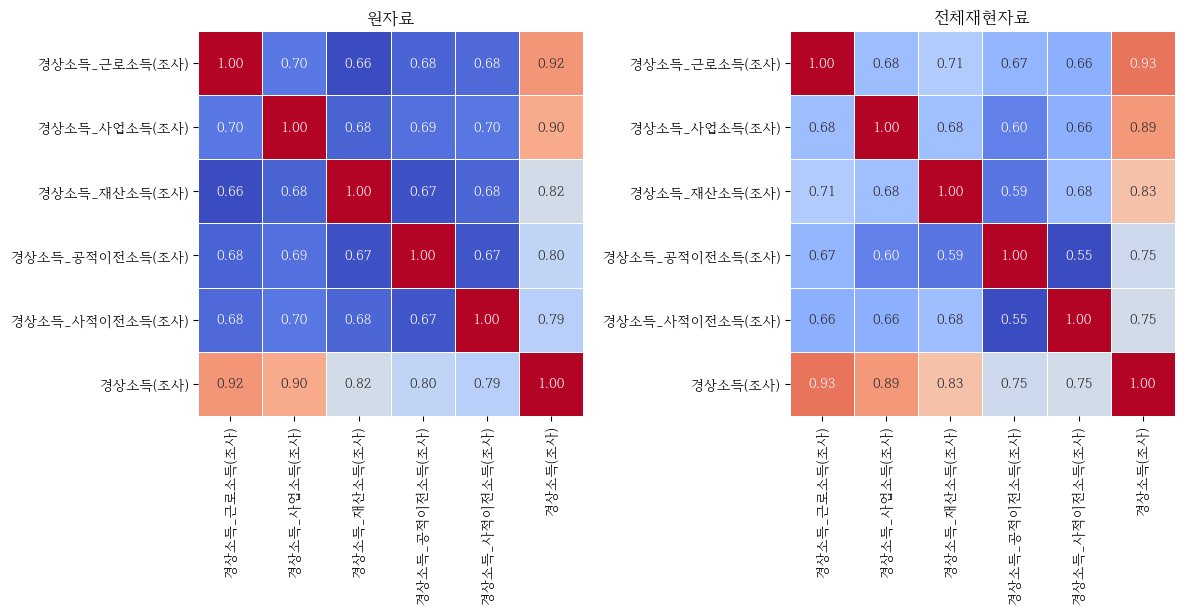

In [257]:
plt.subplot(1,2,1)
plt.rcParams["figure.figsize"] = (14,5)
sns.heatmap(non_rho4_mvn[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True , cbar = False)
plt.title("원자료")

plt.subplot(1,2,2)
sns.heatmap(TVAE_non_rho4_data[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True , cbar = False)
plt.title("전체재현자료")

#### $\rho$ = 0.9

Text(0.5, 1.0, '전체재현자료')

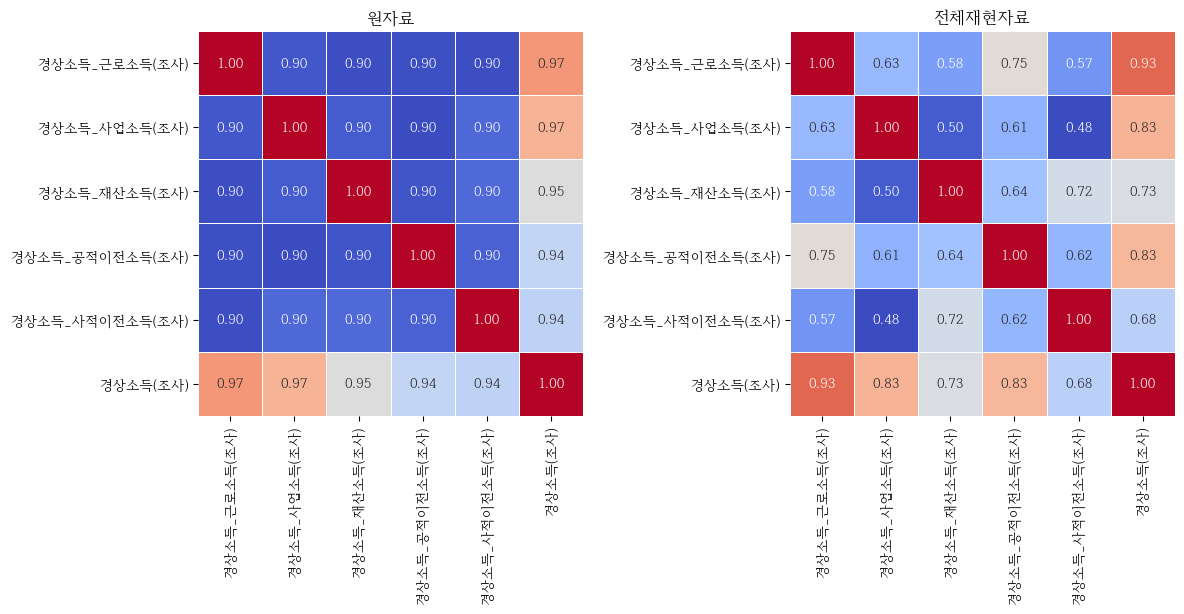

In [258]:
plt.subplot(1,2,1)
plt.rcParams["figure.figsize"] = (14,5)
sns.heatmap(non_rho5_mvn[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True , cbar = False)
plt.title("원자료")

plt.subplot(1,2,2)
sns.heatmap(TVAE_non_rho5_data[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True , cbar = False)
plt.title("전체재현자료")

### 경상소득이 포함된 자료에 대한 상관계수 그래프

#### $\rho$ = 0.1

Text(0.5, 1.0, '전체재현자료')

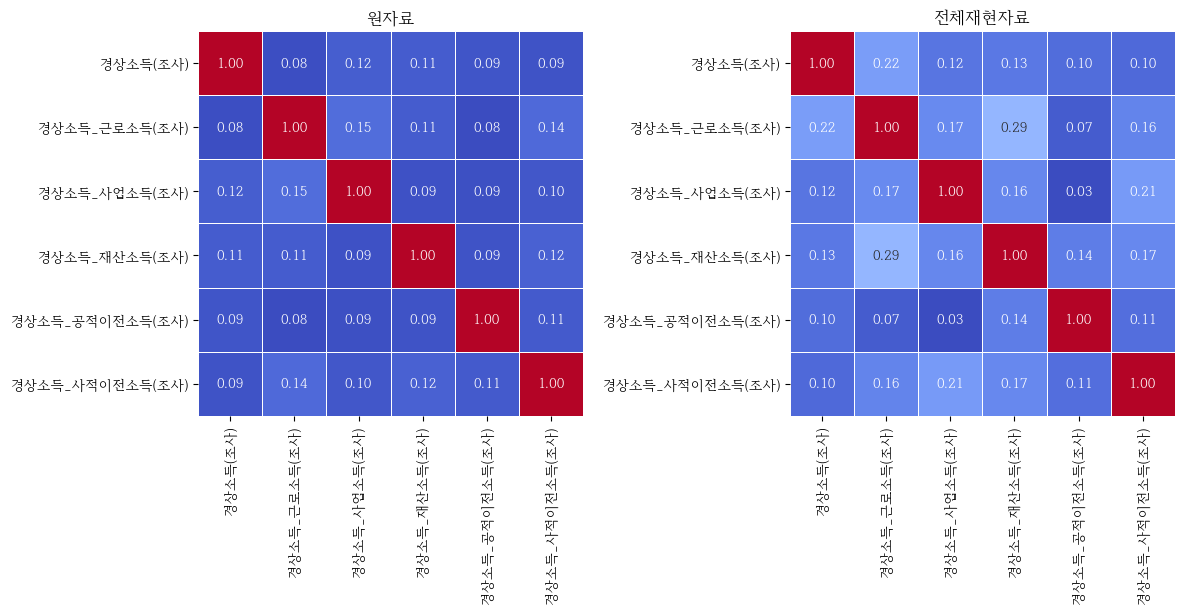

In [259]:
plt.subplot(1,2,1)
plt.rcParams["figure.figsize"] = (14,5)
sns.heatmap(all_rho1_mvn[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True, cbar = False)
plt.title("원자료")

plt.subplot(1,2,2)
sns.heatmap(TVAE_all_rho1_data[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True , cbar = False)
plt.title("전체재현자료")

#### $\rho$ = 0.3

Text(0.5, 1.0, '전체재현자료')

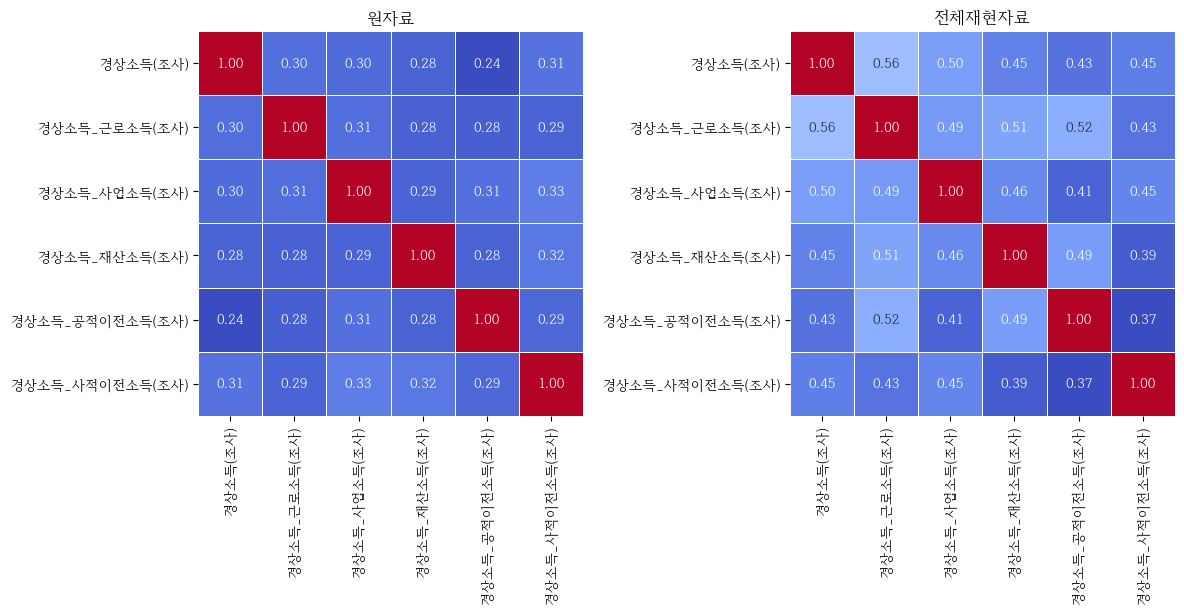

In [260]:
plt.subplot(1,2,1)
plt.rcParams["figure.figsize"] = (14,5)
sns.heatmap(all_rho2_mvn[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True , cbar = False)
plt.title("원자료")

plt.subplot(1,2,2)
sns.heatmap(TVAE_all_rho2_data[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True ,cbar = False)
plt.title("전체재현자료")

#### $\rho$ = 0.5

Text(0.5, 1.0, '전체재현자료')

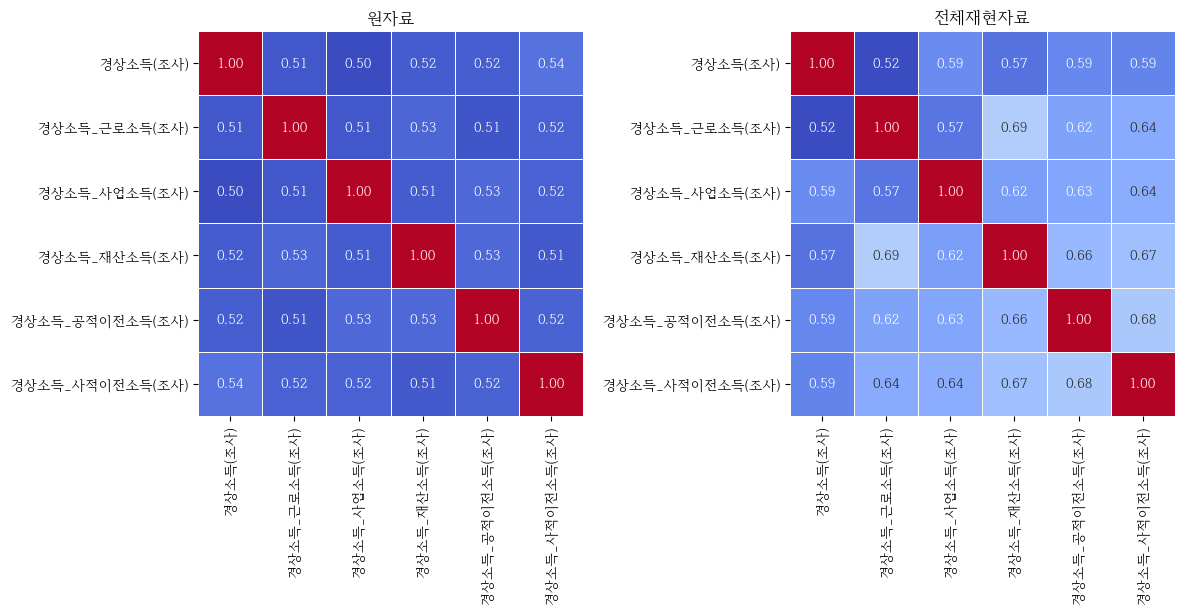

In [261]:
plt.subplot(1,2,1)
plt.rcParams["figure.figsize"] = (14,5)
sns.heatmap(all_rho3_mvn[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True , cbar = False)
plt.title("원자료")

plt.subplot(1,2,2)
sns.heatmap(TVAE_all_rho3_data[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True , cbar = False)
plt.title("전체재현자료")

#### $\rho$ = 0.7

Text(0.5, 1.0, '전체재현자료')

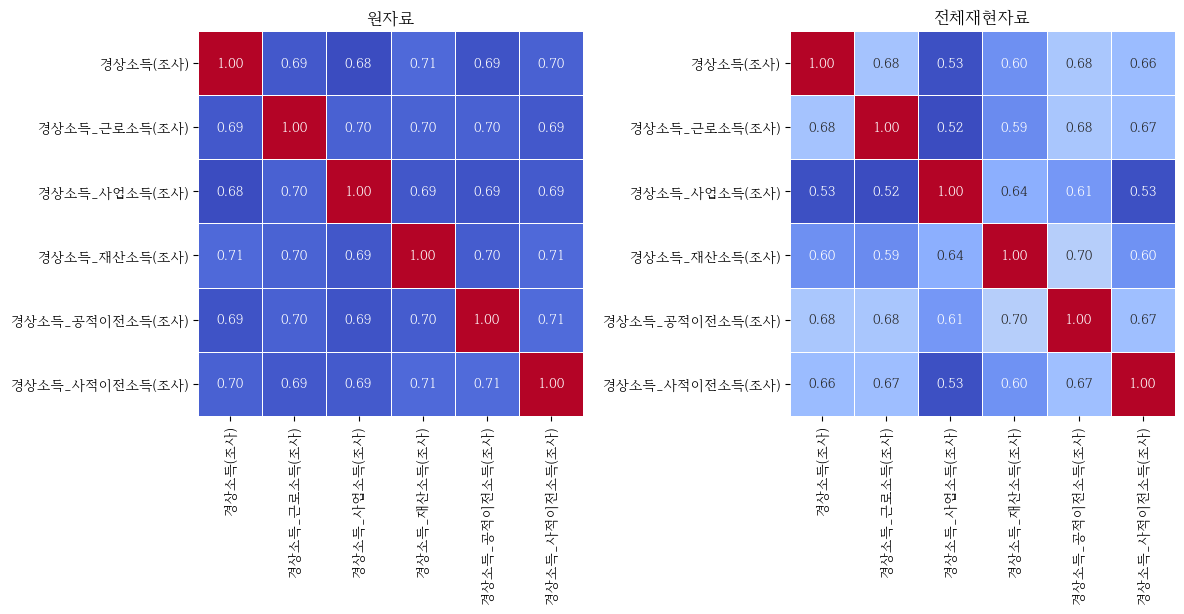

In [262]:
plt.subplot(1,2,1)
plt.rcParams["figure.figsize"] = (14,5)
sns.heatmap(all_rho4_mvn[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True , cbar = False)
plt.title("원자료")

plt.subplot(1,2,2)
sns.heatmap(TVAE_all_rho4_data[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True , cbar = False)
plt.title("전체재현자료")

#### $\rho$ = 0.9

Text(0.5, 1.0, '전체재현자료')

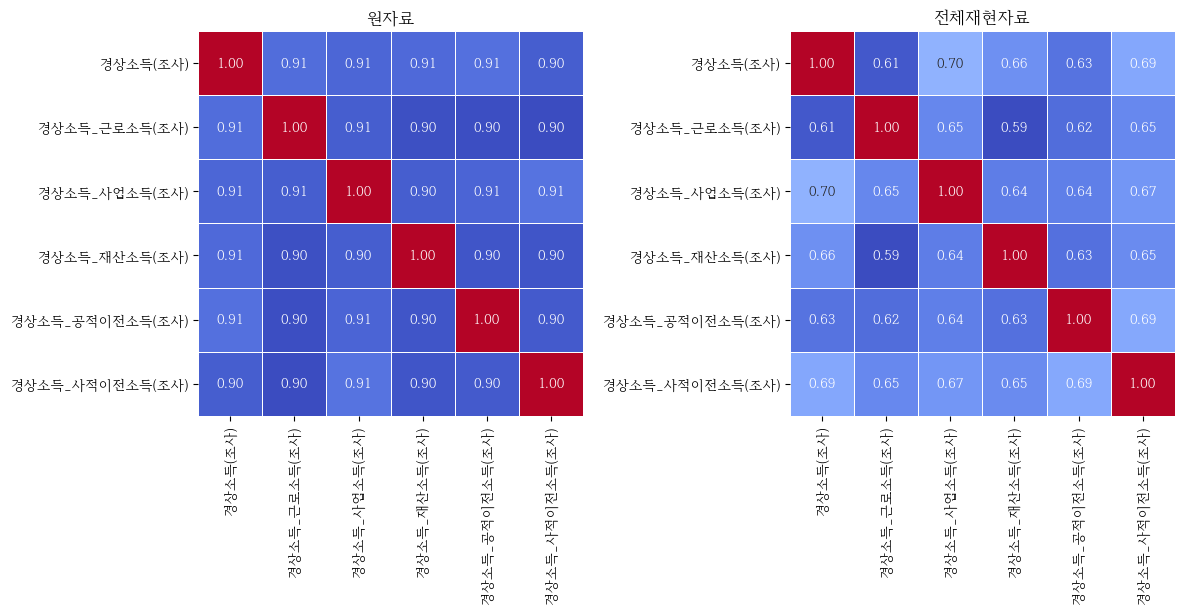

In [263]:
plt.subplot(1,2,1)
plt.rcParams["figure.figsize"] = (14,5)
sns.heatmap(all_rho5_mvn[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True , cbar = False)
plt.title("원자료")

plt.subplot(1,2,2)
sns.heatmap(TVAE_all_rho5_data[0].iloc[:,1:7].corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True , cbar = False)
plt.title("전체재현자료")

## KSComplement ( 원자료 , 재현자료 , 변수 , 반복횟수 ) - 실제자료와 재현자료간의 유사성 측정

In [223]:
def KSComplements(oridata , synthetic_data , variable , iteration) : 
    
    KSComplement_Result = []       

    for i in range(iteration) : 
        KSComplement_Result.append(
            KSComplement.compute(
                real_data = oridata[i][variable],
                synthetic_data = synthetic_data[i][variable]))
        
    return KSComplement_Result 

In [224]:
KS1 = KSComplements(non_rho1_mvn , TVAE_non_rho1_data , '경상소득(조사)' , 500)
KS2 = KSComplements(non_rho2_mvn , TVAE_non_rho2_data , '경상소득(조사)' , 500)
KS3 = KSComplements(non_rho3_mvn , TVAE_non_rho3_data , '경상소득(조사)' , 500)
KS4 = KSComplements(non_rho4_mvn , TVAE_non_rho4_data , '경상소득(조사)' , 500)
KS5 = KSComplements(non_rho5_mvn , TVAE_non_rho5_data , '경상소득(조사)' , 500)

In [225]:
AKS1 = KSComplements(all_rho1_mvn , TVAE_all_rho1_data , '경상소득(조사)' , 500)
AKS2 = KSComplements(all_rho2_mvn , TVAE_all_rho2_data , '경상소득(조사)' , 500)
AKS3 = KSComplements(all_rho3_mvn , TVAE_all_rho3_data , '경상소득(조사)' , 500)
AKS4 = KSComplements(all_rho4_mvn , TVAE_all_rho4_data , '경상소득(조사)' , 500)
AKS5 = KSComplements(all_rho5_mvn , TVAE_all_rho5_data , '경상소득(조사)' , 500)

In [226]:
def calculate_statistics(data):
    results = {
        'mean': np.array(np.mean(data)),
        'std': np.array(np.std(data))}
    return results

In [227]:
def measure_dataframe(data1 , data2 , data3 , data4 ,data5):
    
    result = np.array([[np.mean(data1) , np.std(data1)] , [np.mean(data2) , np.std(data2)] , [np.mean(data3) , np.std(data3)] , [np.mean(data4) , np.std(data4)] , [np.mean(data5) , np.std(data5)]])
    frame = pd.DataFrame(result)
    frame.columns = ["척도의 평균" , "척도의 표준편차"]
    frame.index = ['0.1','0.3','0.5','0.7','0.9']
    
    return pd.DataFrame(frame )


경상소득(조사) 미포함

In [228]:
measure_dataframe(KS1 , KS2 , KS3 , KS4 , KS5)

,척도의 평균,척도의 표준편차
0.1,0.779722,0.119783
0.3,0.831921,0.077368
0.5,0.850020,0.050689
0.7,0.866981,0.045886
0.9,0.886114,0.037460


경상소득(조사) 포함

In [229]:
measure_dataframe(AKS1 , AKS2 , AKS3 , AKS4 , AKS5)

,척도의 평균,척도의 표준편차
0.1,0.726482,0.120308
0.3,0.795029,0.095547
0.5,0.837738,0.069176
0.7,0.862439,0.058196
0.9,0.881410,0.045771


### CorrelationSimilarity ( 원자료 , 재현자료 , 변수1 , 변수2 , 피어슨 OR 스피어만 , 반복횟수 ) - 상관관계 측정 및 유사성 계산

In [230]:
def CorrelationSimilaritys(oridata , synthetic_data , variable1 , variable2 , method , iteration) : 
    
    CorrelationSimilarity_Result = [] 

    for i in range(iteration) : 
        CorrelationSimilarity_Result.append(
            CorrelationSimilarity.compute(
                real_data = oridata[i][[variable1 , variable2]],
                synthetic_data = synthetic_data[i][[variable1 , variable2]],
                coefficient = method))
        
    return CorrelationSimilarity_Result 

In [231]:
CS1 = CorrelationSimilaritys(non_rho1_mvn , TVAE_non_rho1_data , '경상소득_근로소득(조사)' , '경상소득_사업소득(조사)' , 'Pearson' , 500)
CS2 = CorrelationSimilaritys(non_rho2_mvn , TVAE_non_rho2_data , '경상소득_근로소득(조사)' , '경상소득_사업소득(조사)' , 'Pearson' , 500)
CS3 = CorrelationSimilaritys(non_rho3_mvn , TVAE_non_rho3_data , '경상소득_근로소득(조사)' , '경상소득_사업소득(조사)' , 'Pearson' , 500)
CS4 = CorrelationSimilaritys(non_rho4_mvn , TVAE_non_rho4_data , '경상소득_근로소득(조사)' , '경상소득_사업소득(조사)' , 'Pearson' , 500)
CS5 = CorrelationSimilaritys(non_rho5_mvn , TVAE_non_rho5_data , '경상소득_근로소득(조사)' , '경상소득_사업소득(조사)' , 'Pearson' , 500)

In [232]:
ACS1 = CorrelationSimilaritys(all_rho1_mvn , TVAE_all_rho1_data , '경상소득_근로소득(조사)' , '경상소득_사업소득(조사)' , 'Pearson' , 500)
ACS2 = CorrelationSimilaritys(all_rho2_mvn , TVAE_all_rho2_data , '경상소득_근로소득(조사)' , '경상소득_사업소득(조사)' , 'Pearson' , 500)
ACS3 = CorrelationSimilaritys(all_rho3_mvn , TVAE_all_rho3_data , '경상소득_근로소득(조사)' , '경상소득_사업소득(조사)' , 'Pearson' , 500)
ACS4 = CorrelationSimilaritys(all_rho4_mvn , TVAE_all_rho4_data , '경상소득_근로소득(조사)' , '경상소득_사업소득(조사)' , 'Pearson' , 500)
ACS5 = CorrelationSimilaritys(all_rho5_mvn , TVAE_all_rho5_data , '경상소득_근로소득(조사)' , '경상소득_사업소득(조사)' , 'Pearson' , 500)

경상소득(조사) 미포함

In [233]:
measure_dataframe(CS1 , CS2 , CS3 , CS4 , CS5)

,척도의 평균,척도의 표준편차
0.1,0.963082,0.029417
0.3,0.921556,0.043059
0.5,0.942776,0.028807
0.7,0.973521,0.023828
0.9,0.895866,0.023983


경상소득(조사) 포함

In [234]:
measure_dataframe(ACS1 , ACS2 , ACS3 , ACS4 , ACS5)

,척도의 평균,척도의 표준편차
0.1,0.961855,0.028313
0.3,0.909928,0.046141
0.5,0.940638,0.029373
0.7,0.972843,0.023662
0.9,0.891171,0.024726


### RangeCoverage ( 원자료 , 재현자료 , 변수 , 반복횟수 ) - 재현자료의 열이 실제 데이터의 열의 모든범위의 값을 포함하는지 여부

In [235]:
def RangeCoverages(oridata , synthetic_data , variable , iteration) : 
    
    RangeCoverage_Result = [] 
    
    for i in range(iteration) :
        RangeCoverage_Result.append(
            RangeCoverage.compute(
                real_data = oridata[i][variable],
                synthetic_data = synthetic_data[i][variable]))
        
    return RangeCoverage_Result
    

In [236]:
RC1 = RangeCoverages(non_rho1_mvn , TVAE_non_rho1_data , '경상소득(조사)' , 500)
RC2 = RangeCoverages(non_rho2_mvn , TVAE_non_rho2_data , '경상소득(조사)' , 500)
RC3 = RangeCoverages(non_rho3_mvn , TVAE_non_rho3_data , '경상소득(조사)' , 500)
RC4 = RangeCoverages(non_rho4_mvn , TVAE_non_rho4_data , '경상소득(조사)' , 500)
RC5 = RangeCoverages(non_rho5_mvn , TVAE_non_rho5_data , '경상소득(조사)' , 500)

In [237]:
ARC1 = RangeCoverages(all_rho1_mvn , TVAE_all_rho1_data , '경상소득(조사)' , 500)
ARC2 = RangeCoverages(all_rho2_mvn , TVAE_all_rho2_data , '경상소득(조사)' , 500)
ARC3 = RangeCoverages(all_rho3_mvn , TVAE_all_rho3_data , '경상소득(조사)' , 500)
ARC4 = RangeCoverages(all_rho4_mvn , TVAE_all_rho4_data , '경상소득(조사)' , 500)
ARC5 = RangeCoverages(all_rho5_mvn , TVAE_all_rho5_data , '경상소득(조사)' , 500)

경상소득(조사) 미포함

In [238]:
measure_dataframe(RC1 , RC2 , RC3 , RC4 , RC5)

,척도의 평균,척도의 표준편차
0.1,0.757861,0.099323
0.3,0.781603,0.076546
0.5,0.729809,0.069437
0.7,0.671522,0.065756
0.9,0.629969,0.062322


경상소득(조사) 포함

In [239]:
measure_dataframe(ARC1 , ARC2 , ARC3 , ARC4 , ARC5)

,척도의 평균,척도의 표준편차
0.1,0.724994,0.115598
0.3,0.771844,0.092396
0.5,0.775897,0.092463
0.7,0.775362,0.090748
0.9,0.767197,0.087733


### BoundaryAdherence ( 원자료 , 재현자료 , 변수 , 반복횟수) - 재현자료가 실제자료의 최소값과 최대값을 준수하는지 여부를 결정

In [240]:
def BoundaryAdherences(oridata , synthetic_data , variable , iteration): 
    
    BoundaryAdherence_Result = []
    
    for i in range(iteration) : 
        BoundaryAdherence_Result.append(
            BoundaryAdherence.compute(
                real_data = oridata[i][variable],
                synthetic_data = synthetic_data[i][variable]))
        
    return BoundaryAdherence_Result

In [242]:
BA1 = BoundaryAdherences(non_rho1_mvn , TVAE_non_rho1_data , '경상소득(조사)' , 500)
BA2 = BoundaryAdherences(non_rho2_mvn , TVAE_non_rho2_data , '경상소득(조사)' , 500)
BA3 = BoundaryAdherences(non_rho3_mvn , TVAE_non_rho3_data , '경상소득(조사)' , 500)
BA4 = BoundaryAdherences(non_rho4_mvn , TVAE_non_rho4_data , '경상소득(조사)' , 500)
BA5 = BoundaryAdherences(non_rho5_mvn , TVAE_non_rho5_data , '경상소득(조사)' , 500)

In [243]:
ABA1 = BoundaryAdherences(all_rho1_mvn , TVAE_all_rho1_data , '경상소득(조사)' , 500)
ABA2 = BoundaryAdherences(all_rho2_mvn , TVAE_all_rho2_data , '경상소득(조사)' , 500)
ABA3 = BoundaryAdherences(all_rho3_mvn , TVAE_all_rho3_data , '경상소득(조사)' , 500)
ABA4 = BoundaryAdherences(all_rho4_mvn , TVAE_all_rho4_data , '경상소득(조사)' , 500)
ABA5 = BoundaryAdherences(all_rho5_mvn , TVAE_all_rho5_data , '경상소득(조사)' , 500)

경상소득(조사) 미포함

In [244]:
measure_dataframe(BA1 , BA2 , BA3 , BA4 , BA5)

,척도의 평균,척도의 표준편차
0.1,0.999870,0.000473
0.3,0.999951,0.000203
0.5,0.999997,0.000042
0.7,0.999998,0.000035
0.9,1.000000,0.000000


경상소득(조사) 포함

In [245]:
measure_dataframe(ABA1 , ABA2 , ABA3 , ABA4 , ABA5)

,척도의 평균,척도의 표준편차
0.1,1.0,0.0
0.3,1.0,0.0
0.5,1.0,0.0
0.7,1.0,0.0
0.9,1.0,0.0


### KL DIVERGENCE ( 원자료 , 재현자료 , 변수 , 반복횟수 ) 

In [246]:
"""ColumnPair metrics based on Kullback–Leibler Divergence."""

import numpy as np
import pandas as pd
from scipy.special import kl_div

from sdmetrics.column_pairs.base import ColumnPairsMetric
from sdmetrics.goal import Goal
from sdmetrics.utils import get_frequencies


class ContinuousKLDivergence(ColumnPairsMetric):
    """Continuous Kullback–Leibler Divergence based metric.

    This approximates the KL divergence by binning the continuous values
    to turn them into categorical values and then computing the relative
    entropy. Afterwards normalizes the value applying ``1 / (1 + KLD)``.

    Attributes:
        name (str):
            Name to use when reports about this metric are printed.
        goal (sdmetrics.goal.Goal):
            The goal of this metric.
        min_value (Union[float, tuple[float]]):
            Minimum value or values that this metric can take.
        max_value (Union[float, tuple[float]]):
            Maximum value or values that this metric can take.
    """

    name = 'Continuous Kullback–Leibler Divergence'
    goal = Goal.MAXIMIZE
    min_value = 0.0
    max_value = 1.0

    @staticmethod
    def compute(real_data, synthetic_data):
        """Compare two pairs of continuous columns using Kullback–Leibler Divergence.

        Args:
            real_data (pandas.DataFrame):
                The values from the real dataset, passed as pandas.DataFrame
                with 2 columns.
            synthetic_data (pandas.DataFrame):
                The values from the synthetic dataset, passed as a
                pandas.DataFrame with 2 columns.

        Returns:
            Union[float, tuple[float]]:
                Metric output.
        """
        real_data[pd.isna(real_data)] = 0.0
        synthetic_data[pd.isna(synthetic_data)] = 0.0
        column1 = '경상소득_근로소득(조사)'
        column2 = '경상소득(조사)'
        
        real, xedges, yedges = np.histogram2d(real_data[column1], real_data[column2])
        synthetic, _, _ = np.histogram2d(
            synthetic_data[column1], synthetic_data[column2], bins=[xedges, yedges])

        f_obs, f_exp = synthetic.flatten() + 1e-5, real.flatten() + 1e-5
        f_obs, f_exp = f_obs / np.sum(f_obs), f_exp / np.sum(f_exp)

        return 1 / (1 + np.sum(kl_div(f_obs, f_exp)))

    @classmethod
    def normalize(cls, raw_score):
        """Return the `raw_score` as is, since it is already normalized.

        Args:
            raw_score (float):
                The value of the metric from `compute`.

        Returns:
            float:
                The normalized value of the metric
        """
        return super().normalize(raw_score)

In [247]:
continous_k1_metric = ContinuousKLDivergence()

In [248]:
def KLD(oridata, synthetic_data , iteration) : # 이용 변수 : 경상소득(조사) , 경상소득_근로소득(조사)
    
    KLD_Result = [] 
    
    for i in range(iteration) : 
        KLD_Result.append(
            continous_k1_metric.compute(oridata[i] , synthetic_data[i]))
    
    return KLD_Result

In [249]:
KL1 = KLD(non_rho1_mvn ,  TVAE_non_rho1_data , 500)
KL2 = KLD(non_rho2_mvn ,  TVAE_non_rho2_data , 500)
KL3 = KLD(non_rho3_mvn ,  TVAE_non_rho3_data , 500)
KL4 = KLD(non_rho4_mvn ,  TVAE_non_rho4_data , 500)
KL5 = KLD(non_rho5_mvn ,  TVAE_non_rho5_data , 500)

In [250]:
AKL1 = KLD(all_rho1_mvn , TVAE_all_rho1_data , 500)
AKL2 = KLD(all_rho2_mvn , TVAE_all_rho2_data , 500)
AKL3 = KLD(all_rho3_mvn , TVAE_all_rho3_data , 500)
AKL4 = KLD(all_rho4_mvn , TVAE_all_rho4_data , 500)
AKL5 = KLD(all_rho5_mvn , TVAE_all_rho5_data , 500)

경상소득(조사) 미포함

In [251]:
measure_dataframe(KL1 , KL2 , KL3 , KL4 , KL5)

,척도의 평균,척도의 표준편차
0.1,0.697422,0.100039
0.3,0.749732,0.074531
0.5,0.771333,0.058264
0.7,0.782361,0.064003
0.9,0.651433,0.083876


경상소득(조사) 포함

In [252]:
measure_dataframe(AKL1 , AKL2 , AKL3 , AKL4 , AKL5)

,척도의 평균,척도의 표준편차
0.1,0.655991,0.093566
0.3,0.720439,0.068980
0.5,0.750239,0.059106
0.7,0.757208,0.074134
0.9,0.537756,0.083277
